# Scalabilité - Projet: Twitter Sentiment Analysis

L'objectif ici est d'évaluer la scalabilité de notre modèle en le testant sur un autre jeu de données. 
Dans ce fichier, le jeu de données choisi est celui des SMS reçus classés comme SPAM ou pas SPAM.

In [1]:
#Path pour les fichiers
file_path_data = 'data/data_clean/'
file_path_data_scalability = 'data_scalability/spam/'
trained_model_path = 'models_training/Best_models_A/'

# I. Importation des packages nécessaires et des jeux de données

# 1. Importation des packages

In [87]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re 
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk import word_tokenize, pos_tag, sent_tokenize 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import linear_model
import pickle
from sklearn.metrics import classification_report

# 2. Importation du jeu de données: Tweets

In [88]:
df = pd.read_csv(file_path_data+'data_clean.csv', index_col = 0)

On affiche ici les informations sur le dataframe df:

In [89]:
print("Le nombre de tweets positifs est:", (df[df.target == 4].shape[0]))
print("Le nombre de tweets négatif est:", (df[df.target == 0].shape[0]))
print("Le nombre de valeurs manquante:\n" + str(pd.isnull(df).sum()))

Le nombre de tweets positifs est: 99968
Le nombre de tweets négatif est: 99977
Le nombre de valeurs manquante:
target                   0
ids                      0
date                     0
flag                     0
user                     0
text                     0
clean_text               0
clean_text_tagged        0
clean_text_tagged_bis    0
dtype: int64


In [90]:
df.head()

,target,ids,date,flag,user,text,clean_text,clean_text_tagged,clean_text_tagged_bis
index,,,,,,,,,
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",switchfoot awww bummer shoulda got david carr ...,"[('switchfoot', 'NN'), ('awww', 'NN'), ('bumme...","('switchfoot', 'NN'), ('awww', 'NN'), ('bummer..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,upset update facebook texting might cry result...,"[('upset', 'JJ'), ('update', 'JJ'), ('facebook...","('upset', 'JJ'), ('update', 'JJ'), ('facebook'..."
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,kenichan dived many times ball managed save 50...,"[('kenichan', 'NNS'), ('dived', 'VBD'), ('many...","('kenichan', 'NNS'), ('dived', 'VBD'), ('many'..."
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,whole body feels itchy like fire,"[('whole', 'JJ'), ('body', 'NN'), ('feels', 'N...","('whole', 'JJ'), ('body', 'NN'), ('feels', 'NN..."
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",nationwideclass behaving mad see,"[('nationwideclass', 'NN'), ('behaving', 'NN')...","('nationwideclass', 'NN'), ('behaving', 'NN'),..."


In [91]:
X = df['text']
y = df.target

In [92]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2, random_state = 0)

In [93]:
vectorizer = pickle.load(open(trained_model_path+'vectorizer.sav', 'rb'))
X_test = vectorizer.transform(X_test)

# 3. Importation du jeu de données: SMS

In [94]:
sms = pd.read_csv(file_path_data_scalability+'spam.csv',encoding = "ISO-8859-1")

In [95]:
sms.rename(columns={"v1": "target", "v2": "text"}, inplace=True)
sms.drop(["Unnamed: 2","Unnamed: 3","Unnamed: 4"],axis=1, inplace=True)
sms['target'] = sms['target'].replace(['ham','spam'],[4,0])

In [96]:
sms.head()

,target,text
0,4,"Go until jurong point, crazy.. Available only ..."
1,4,Ok lar... Joking wif u oni...
2,0,Free entry in 2 a wkly comp to win FA Cup fina...
3,4,U dun say so early hor... U c already then say...
4,4,"Nah I don't think he goes to usf, he lives aro..."


Montrer les informations de sms, 

In [97]:
print("Le nombre de sms non-spam est:", (sms[sms.target == 4].shape[0]))
print("Le nombre de sms spam est:", (sms[sms.target == 0].shape[0]))
print("Le nombre de valeurs manquante:\n" + str(pd.isnull(sms).sum()))

Le nombre de sms non-spam est: 4825
Le nombre de sms spam est: 747
Le nombre de valeurs manquante:
target    0
text      0
dtype: int64


**Commentaire:** 
    - Notre jeu de données contient plus de SMS non-spam que de SMS indésirables.
    - Notre jeu de données ne comporte pas de valeurs manquantes.

In [98]:
X_sms = sms['text']
y_sms = sms.target
X_sms = vectorizer.transform(X_sms)

# II. Application des modèles entraînés

In [99]:
models_name = ['Logistic', 'Naif bayésien BernoulliNB', 'Naif bayésien MultinomialNB', 'KNeighbors', 'Decision Tree',
              'Random Forest', 'XGBoost', 'GradientBoosting', 'AdaBoost']
trained_models = ['logreg','ber','nb','knn','dc','rf','xgb','gradbt','ac' ]

In [100]:
def test(models_name, trained_models, X_test, y_test, s = 'tweets'):
    prediction = dict()
    for i in range(len(models_name)):
        model = pickle.load(open(trained_model_path+trained_models[i]+'.sav', 'rb'))     
        prediction[models_name[i] + '_' + s ] = model.predict(X_test) #save the prediction to dictionary
        print("\n"+"="*40+models_name[i]+"="*40+"\n")
        print("Evaluation détaillée de la Classification par " + models_name[i] +":\n \n", classification_report(y_test,prediction[models_name[i] + '_' + s]))
        confusion_matrix = pd.crosstab(y_test, prediction[models_name[i] + '_' + s], rownames=['Classe réelle'],colnames=['Classe prédite'])
        print("La matrice de confusion pour la Classification par " + models_name[i] +" :\n \n" ,confusion_matrix)
        accuracy = model.score(X_test, y_test)
        print("Le score pour la Classification par " + models_name[i] + ": ",accuracy)
    return prediction

# 1. Apprentissage avec le jeu de données Tweets

In [101]:
prediction_tweets = test(models_name, trained_models, X_test, y_test, s = 'tweets') # It takes about 5 mins


========================================Logistic========================================

Evaluation détaillée de la Classification par Logistic:
 
               precision    recall  f1-score   support

           0       0.80      0.78      0.79     19887
           4       0.78      0.81      0.80     20102

    accuracy                           0.79     39989
   macro avg       0.79      0.79      0.79     39989
weighted avg       0.79      0.79      0.79     39989

La matrice de confusion pour la Classification par Logistic :
 
 Classe prédite      0      4
Classe réelle               
0               15428   4459
4                3892  16210
Le score pour la Classification par Logistic:  0.7911675710820476

========================================Naif bayésien BernoulliNB========================================

Evaluation détaillée de la Classification par Naif bayésien BernoulliNB:
 
               precision    recall  f1-score   support

           0       0.76      0.81    

# 2. Apprentissage avec le jeu de données: SMS

In [102]:
prediction_sms = test(models_name, trained_models, X_sms, y_sms, s = 'sms') # It takes about 5 mins


========================================Logistic========================================

Evaluation détaillée de la Classification par Logistic:
 
               precision    recall  f1-score   support

           0       0.09      0.24      0.13       747
           4       0.84      0.63      0.72      4825

    accuracy                           0.58      5572
   macro avg       0.47      0.44      0.43      5572
weighted avg       0.74      0.58      0.65      5572

La matrice de confusion pour la Classification par Logistic :
 
 Classe prédite     0     4
Classe réelle             
0                179   568
4               1763  3062
Le score pour la Classification par Logistic:  0.5816582914572864

========================================Naif bayésien BernoulliNB========================================

Evaluation détaillée de la Classification par Naif bayésien BernoulliNB:
 
               precision    recall  f1-score   support

           0       0.09      0.31      0.14  

**Commentaire:** _On remarque que notre modèle appliqué au jeu de données SMS fournit des résultats modestes avec un score maximum de 61% avec XGBoost et GradientBoosting._

# III. Résultats

In [103]:
prediction = {**prediction_tweets, **prediction_sms}

## 1. Matrices de confusion

In [104]:
classes= (0,4)
def plot_confusion_matrix(cm, cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.tight_layout()
    plt.ylabel('Vrais labels')
    plt.xlabel('Labels prédits')

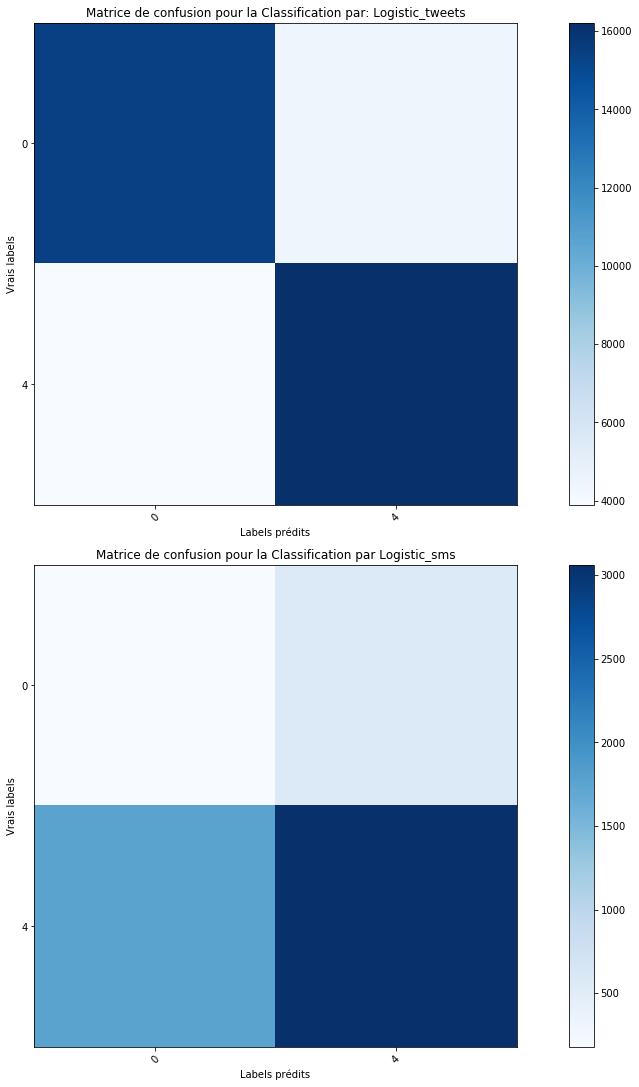

In [105]:
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(15,15))
plt.subplot(2,1,1)
plt.title('Matrice de confusion pour la Classification par: Logistic_tweets')
cm_model = confusion_matrix(y_test,prediction['Logistic_tweets'])
plot_confusion_matrix(cm_model)
plt.subplot(2,1,2)
cm_model1 = confusion_matrix(y_sms, prediction['Logistic_sms'])
plt.title('Matrice de confusion pour la Classification par Logistic_sms')
plot_confusion_matrix(cm_model1)

**Commentaire:** _La matrice de confusion colorée confirme les résulats modestes obtenus précédemment._

## 2. Courbes de ROC

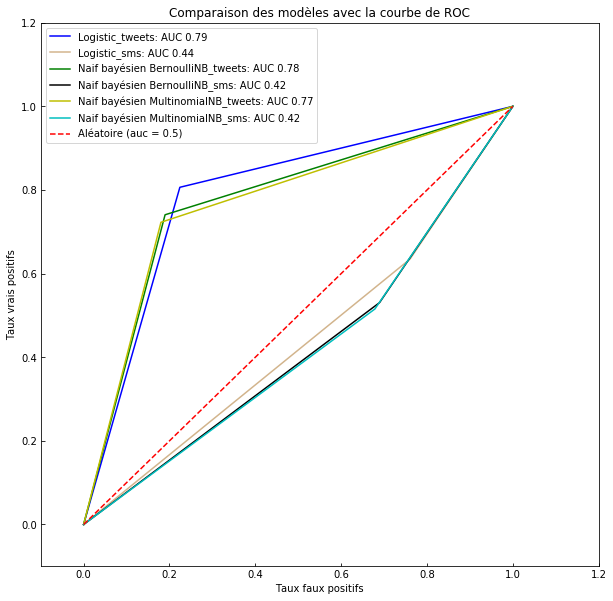

In [106]:
from sklearn.metrics import roc_curve,auc
cmp = 0
colors = ['b', 'g', 'y', 'tan', 'k','c','fuchsia','grey','orange','purple']
models_name = ['Logistic', 'Naif bayésien BernoulliNB', 'Naif bayésien MultinomialNB']
plt.figure(figsize=(10,10))
for i in range(len(models_name)):

    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, prediction[models_name[i]+'_tweets'],pos_label=4)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    plt.plot(false_positive_rate, true_positive_rate, colors[i], label='%s: AUC %0.2f'% (models_name[i]+'_tweets',roc_auc))

    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_sms, prediction[models_name[i]+'_sms'],pos_label=4)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    plt.plot(false_positive_rate, true_positive_rate, colors[i+3], label='%s: AUC %0.2f'% (models_name[i]+'_sms',roc_auc))

plt.title('Comparaison des modèles avec la courbe de ROC')
plt.plot([0, 1], [0, 1], color='r',linestyle='--',label='Aléatoire (auc = 0.5)')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('Taux vrais positifs')
plt.xlabel('Taux faux positifs')
plt.legend(loc='best')
plt.tick_params(direction='in')
plt.show()

**Commentaire:** _De même, les courbes de ROC donnent un apreçu graphique des résultats précédemment obtenus avec des aires sous la courbes inférieurs à 0.5 pour les différents modèles appliqués au jeu de données SMS.
Ce faible résultat peut s'expliquer par le fait que notre modèle a été entraîné sur un jeu de données de tweets labellisé "positif" ou "négatif" alors que le jeu de données SMS est quant à lui labellisé "SPAM" ou "Pas SPAM"; les résultats ne sont manifestement pas transposables._